In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler , MinMaxScaler, StandardScaler
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input,Flatten,Conv1D,MaxPooling1D
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error , mean_absolute_percentage_error , mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from keras.layers import LSTM
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import MinMaxScaler


## ADASYN Random over-sampling Evaluation

In [2]:
df= pd.read_csv('Heart Disease Data 2015.csv')
df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
df.drop(['Income',"Education",'DiffWalk',"NoDocbcCost","AnyHealthcare",'Veggies',"Fruits","CholCheck"],axis=1,inplace=True)
df.shape
df['HeartDiseaseorAttack'].value_counts()


HeartDiseaseorAttack
0.0    229787
1.0     23893
Name: count, dtype: int64

In [4]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

## splite data

In [5]:
x = df.drop(["HeartDiseaseorAttack"] , axis = 1).values
y = df["HeartDiseaseorAttack"].values

In [6]:
x_AD, y_AD = ADASYN(random_state=42).fit_resample(x, y)
x_train3, x_test3, y_train3, y_test3 = train_test_split(x_AD, y_AD, test_size=0.25, random_state=42)

In [7]:
scaler = MinMaxScaler()
x_train3 = scaler.fit_transform(x_train3)
x_test3 = scaler.transform(x_test3)

## random forest

In [8]:


# Inicjalizacja modelu z domyślnymi parametrami
rf = RandomForestClassifier()

# Określenie siatki parametrów do przetestowania
param_grid = {
    'n_estimators': [100, 200, 300],  # Liczba drzew
    'max_depth': [10, 20, 30],        # Maksymalna głębokość drzewa
    'min_samples_split': [2, 4, 6],   # Minimalna liczba próbek wymagana do podziału węzła
    'min_samples_leaf': [1, 2, 4],    # Minimalna liczba próbek wymagana w liściu
    'max_features': ['auto', 'sqrt']  # Liczba cech do rozważenia przy każdym podziale
}

# Utworzenie obiektu GridSearchCV
cv_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Przeszukiwanie siatki parametrów
cv_rf.fit(x_train3, y_train3)

# Najlepszy zestaw parametrów
print("Najlepsze parametry: ", cv_rf.best_params_)

# Najlepszy estimator
best_rf = cv_rf.best_estimator_

# Predykcje i ocena modelu
ypred_train = best_rf.predict(x_train3)
ypred_test = best_rf.predict(x_test3)

print("Training Results\n")
print(classification_report(y_train3, ypred_train))
print("Test Results\n")
print(classification_report(y_test3, ypred_test))

# Macierz pomyłek
conf_matrix = confusion_matrix(y_test3, ypred_test)
print("Confusion Matrix:\n", conf_matrix)

# Ocena modelu za pomocą walidacji krzyżowej
cross_val_scores = cross_val_score(best_rf, x_train3, y_train3, cv=5)
print("Cross-validation scores:", cross_val_scores)
print("Average cross-validation score:", np.mean(cross_val_scores))

Najlepsze parametry:  {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 300}
Training Results

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95    102726
         1.0       0.97      0.92      0.95    101187

    accuracy                           0.95    203913
   macro avg       0.95      0.95      0.95    203913
weighted avg       0.95      0.95      0.95    203913

Test Results

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     33686
         1.0       0.94      0.88      0.91     34286

    accuracy                           0.91     67972
   macro avg       0.91      0.91      0.91     67972
weighted avg       0.91      0.91      0.91     67972

Confusion Matrix:
 [[31791  1895]
 [ 4232 30054]]
Cross-validation scores: [0.90623544 0.909987   0.91064904 0.9092737  0.9091511 ]
Average cross-validation score: 0.9090592571649718

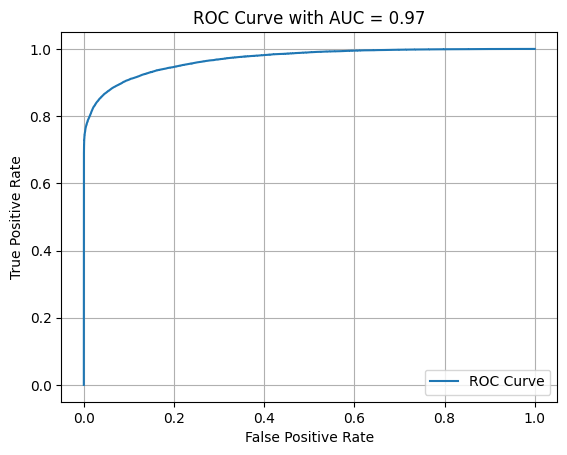

In [9]:

y_proba_test = best_rf.predict_proba(x_test3)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test3, y_proba_test)

plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC = {:.2f}'.format(roc_auc_score(y_test3, y_proba_test)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## DECISION TREE CLASSIFIER

In [10]:

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
}

# Utworzenie modelu drzewa decyzyjnego
tree = DecisionTreeClassifier()

# Uruchomienie Grid Search z walidacją krzyżową
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train3, y_train3)

# Wyświetlenie najlepszych parametrów i wyników
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepsza dokładność:", grid_search.best_score_)

# Utworzenie i ocena modelu z najlepszymi parametrami
best_tree = grid_search.best_estimator_
best_tree.fit(x_train3, y_train3)

ypred_train2 = best_tree.predict(x_train3)
ypred_test2 = best_tree.predict(x_test3)

# Ocena modelu na zbiorze testowym

print("Training Results\n")
print(classification_report(y_train3, ypred_train2))
print('Testing Results\n')
print(classification_report(y_test3, ypred_test2))

# Dodatkowo: Walidacja krzyżowa dla najlepszego modelu na całym zbiorze danych
cross_val_scores = cross_val_score(best_tree, x_train3, y_train3, cv=5)
print("Cross-Validation Scores for the Best Model:", cross_val_scores)
print("Average Cross-Validation Score:", cross_val_scores.mean())

Najlepsze parametry: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Najlepsza dokładność: 0.8789483748564809
Training Results

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95    102726
         1.0       0.96      0.92      0.94    101187

    accuracy                           0.94    203913
   macro avg       0.94      0.94      0.94    203913
weighted avg       0.94      0.94      0.94    203913

Testing Results

              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88     33686
         1.0       0.90      0.85      0.88     34286

    accuracy                           0.88     67972
   macro avg       0.88      0.88      0.88     67972
weighted avg       0.88      0.88      0.88     67972

Cross-Validation Scores for the Best Model: [0.87857686 0.88007258 0.87793934 0.87911333 0.87916238]
Average Cross-Validation Score: 0.8789728969213148


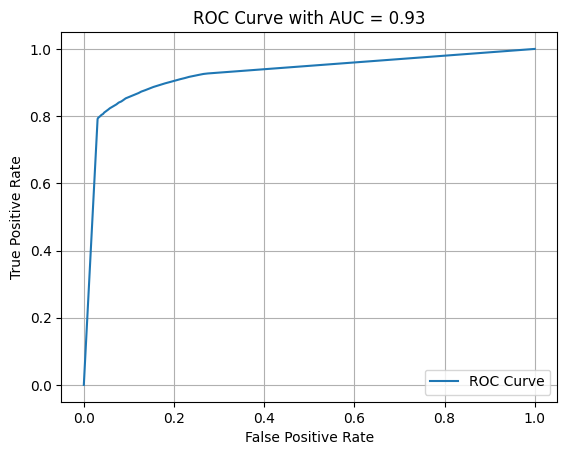

In [11]:

y_proba_test = best_tree.predict_proba(x_test3)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test3, y_proba_test)

plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC = {:.2f}'.format(roc_auc_score(y_test3, y_proba_test)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Naive Bayes

In [12]:
Gnb = GaussianNB()
Gnb.fit(x_train3, y_train3)
ypred_train33 = Gnb.predict(x_train3)
y_pred_test33 = Gnb.predict(x_test3)

print("Naive Bayes Classifier Accuracy: ",accuracy_score(y_test3, y_pred_test33))

Naive Bayes Classifier Accuracy:  0.7156917554287059


In [13]:
print('Testing Results\n')
print(classification_report(y_train3, ypred_train33))

Testing Results

              precision    recall  f1-score   support

         0.0       0.73      0.68      0.70    102726
         1.0       0.70      0.75      0.72    101187

    accuracy                           0.71    203913
   macro avg       0.71      0.71      0.71    203913
weighted avg       0.71      0.71      0.71    203913



In [14]:
print('Testing Results\n')
print(classification_report(y_test3, y_pred_test33))

Testing Results

              precision    recall  f1-score   support

         0.0       0.73      0.68      0.70     33686
         1.0       0.71      0.75      0.73     34286

    accuracy                           0.72     67972
   macro avg       0.72      0.72      0.72     67972
weighted avg       0.72      0.72      0.72     67972



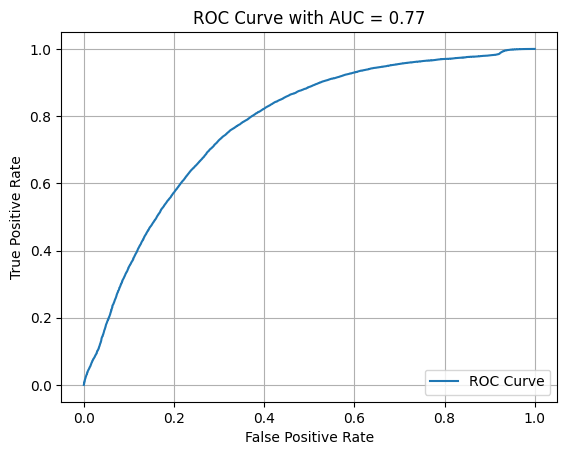

In [15]:

y_proba_test = Gnb.predict_proba(x_test3)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test3, y_proba_test)

plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC = {:.2f}'.format(roc_auc_score(y_test3, y_proba_test)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## XGBOSST


Najlepsze parametry:  {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Accuracy on Training set:  0.9180827117447147
Accuracy on Test set:  0.914361796033661

Training Results

              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92    102726
         1.0       0.97      0.86      0.91    101187

    accuracy                           0.92    203913
   macro avg       0.92      0.92      0.92    203913
weighted avg       0.92      0.92      0.92    203913

Testing Results

              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92     33686
         1.0       0.97      0.85      0.91     34286

    accuracy                           0.91     67972
   macro avg       0.92      0.91      0.91     67972
weighted avg       0.92      0.91      0.91     67972



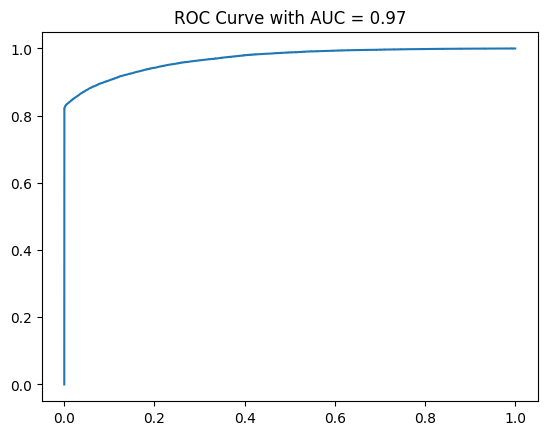

In [16]:

xg = XGBClassifier()

# Definiowanie siatki hiperparametrów do przetestowania
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Utworzenie obiektu GridSearchCV
grid_search = GridSearchCV(estimator=xg, param_grid=param_grid, cv=3, scoring='accuracy')

# Przeszukiwanie siatki parametrów
grid_search.fit(x_train3, y_train3)

# Najlepsze parametry i najlepszy model
print("Najlepsze parametry: ", grid_search.best_params_)
best_xg = grid_search.best_estimator_

# Predykcje na zbiorze treningowym i testowym
ypred_train4 = best_xg.predict(x_train3)
y_pred_test4 = best_xg.predict(x_test3)

# Ocena modelu
print("Accuracy on Training set: ", accuracy_score(y_train3, ypred_train4))
print("Accuracy on Test set: ", accuracy_score(y_test3, y_pred_test4))
print("\nTraining Results\n")
print(classification_report(y_train3, ypred_train4))
print('Testing Results\n')
print(classification_report(y_test3, y_pred_test4))

# Krzywa ROC
y_proba_test4 = best_xg.predict_proba(x_test3)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test3, y_proba_test4)
plt.plot(fpr, tpr)
plt.title("ROC Curve with AUC = {:.2f}".format(roc_auc_score(y_test3, y_proba_test4)))
plt.show()

## logistic regression

Najlepsze parametry:  {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy on Training set:  0.72953171205367
Accuracy on Test set:  0.7323162478667686

Training Results

              precision    recall  f1-score   support

         0.0       0.75      0.70      0.72    102726
         1.0       0.71      0.76      0.74    101187

    accuracy                           0.73    203913
   macro avg       0.73      0.73      0.73    203913
weighted avg       0.73      0.73      0.73    203913

Testing Results

              precision    recall  f1-score   support

         0.0       0.74      0.70      0.72     33686
         1.0       0.72      0.76      0.74     34286

    accuracy                           0.73     67972
   macro avg       0.73      0.73      0.73     67972
weighted avg       0.73      0.73      0.73     67972



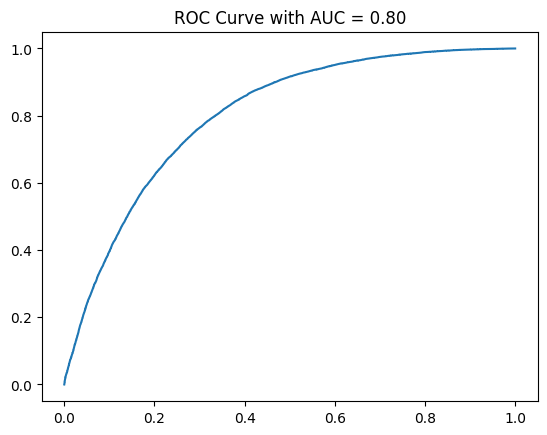

In [17]:

lg = LogisticRegression()

# Definiowanie siatki hiperparametrów do przetestowania
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Parametr regularyzacji
    'penalty': ['l1', 'l2'],       # Typ regularyzacji
    'solver': ['liblinear']        # Algorytm optymalizacji (liblinear jest dobrym wyborem dla małych zbiorów danych)
}

# Utworzenie obiektu GridSearchCV
grid_search = GridSearchCV(estimator=lg, param_grid=param_grid, cv=5, scoring='accuracy')

# Przeszukiwanie siatki parametrów
grid_search.fit(x_train3, y_train3)

# Najlepsze parametry i najlepszy model
print("Najlepsze parametry: ", grid_search.best_params_)
best_lg = grid_search.best_estimator_

# Predykcje na zbiorze treningowym i testowym
ypred_train4 = best_lg.predict(x_train3)
y_pred_test4 = best_lg.predict(x_test3)

# Ocena modelu
print("Accuracy on Training set: ", accuracy_score(y_train3, ypred_train4))
print("Accuracy on Test set: ", accuracy_score(y_test3, y_pred_test4))
print("\nTraining Results\n")
print(classification_report(y_train3, ypred_train4))
print('Testing Results\n')
print(classification_report(y_test3, y_pred_test4))

# Krzywa ROC
y_proba_test4 = best_lg.predict_proba(x_test3)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test3, y_proba_test4)
plt.plot(fpr, tpr)
plt.title("ROC Curve with AUC = {:.2f}".format(roc_auc_score(y_test3, y_proba_test4)))
plt.show()

## GradientBoostingClassifier

Najlepsze parametry:  {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy on Training set:  0.9248453997538166
Accuracy on Test set:  0.9195698228682399

Training Results

              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93    102726
         1.0       0.98      0.87      0.92    101187

    accuracy                           0.92    203913
   macro avg       0.93      0.92      0.92    203913
weighted avg       0.93      0.92      0.92    203913

Testing Results

              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92     33686
         1.0       0.98      0.86      0.92     34286

    accuracy                           0.92     67972
   macro avg       0.93      0.92      0.92     67972
weighted avg       0.93      0.92      0.92     67972



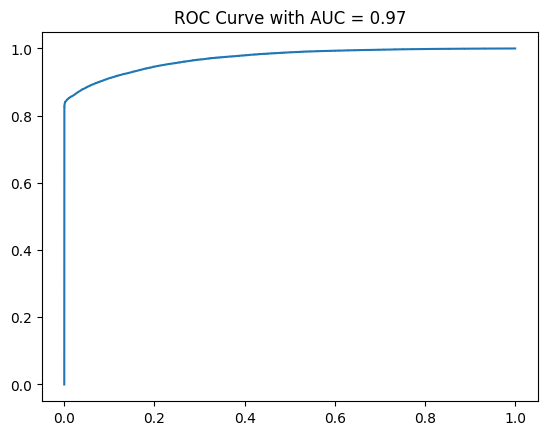

In [18]:


# Inicjalizacja modelu Gradient Boosting Classifier
gb = GradientBoostingClassifier()

# Definiowanie siatki hiperparametrów do przetestowania
param_grid = {
    'n_estimators': [100, 200, 300],  # Liczba drzew w ensemble
    'learning_rate': [0.01, 0.1, 0.2], # Szybkość uczenia
    'max_depth': [3, 5, 7],            # Maksymalna głębokość drzewa
    'min_samples_split': [2, 4],       # Minimalna liczba próbek wymagana do podziału węzła
    'min_samples_leaf': [1, 2]         # Minimalna liczba próbek w liściu
}

# Utworzenie obiektu GridSearchCV
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='accuracy')

# Przeszukiwanie siatki parametrów
grid_search.fit(x_train3, y_train3)

# Najlepsze parametry i najlepszy model
print("Najlepsze parametry: ", grid_search.best_params_)
best_gb = grid_search.best_estimator_

# Predykcje na zbiorze treningowym i testowym
ypred_train6 = best_gb.predict(x_train3)
y_pred_test6 = best_gb.predict(x_test3)

# Ocena modelu
print("Accuracy on Training set: ", accuracy_score(y_train3, ypred_train6))
print("Accuracy on Test set: ", accuracy_score(y_test3, y_pred_test6))
print("\nTraining Results\n")
print(classification_report(y_train3, ypred_train6))
print('Testing Results\n')
print(classification_report(y_test3, y_pred_test6))

# Krzywa ROC
y_proba_test6 = best_gb.predict_proba(x_test3)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test3, y_proba_test6)
plt.plot(fpr, tpr)
plt.title("ROC Curve with AUC = {:.2f}".format(roc_auc_score(y_test3, y_proba_test6)))
plt.show()

## KNN

In [19]:
knn = KNeighborsClassifier()
knn.fit(x_train3, y_train3)

KNeighborsClassifier()

In [20]:
grid_cv = GridSearchCV(KNeighborsClassifier(), 
                       param_grid={
                           "n_neighbors": range(1, 50)
                       }, cv=5, scoring="f1", 
                       verbose=1, n_jobs=6)

In [21]:
grid_cv.fit(x_train3, 
            y_train3)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=6,
             param_grid={'n_neighbors': range(1, 50)}, scoring='f1', verbose=1)

In [22]:
grid_cv.best_score_

0.8596987413054183

In [23]:
knn = grid_cv.best_estimator_
knn

KNeighborsClassifier(n_neighbors=1)

In [24]:
ypred_train83 = grid_cv.predict(x_train3)
y_pred_test83 = grid_cv.predict(x_test3)
print("XGBClassifier Accuracy: ",accuracy_score(y_test3, y_pred_test83))

XGBClassifier Accuracy:  0.8689460366033073


In [25]:
print("Training Results\n")
print(classification_report(y_train3, ypred_train83))

Training Results

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    102726
         1.0       0.99      0.99      0.99    101187

    accuracy                           0.99    203913
   macro avg       0.99      0.99      0.99    203913
weighted avg       0.99      0.99      0.99    203913



In [26]:
print('Testing Results\n')
print(classification_report(y_test3, y_pred_test83))

Testing Results

              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87     33686
         1.0       0.86      0.88      0.87     34286

    accuracy                           0.87     67972
   macro avg       0.87      0.87      0.87     67972
weighted avg       0.87      0.87      0.87     67972



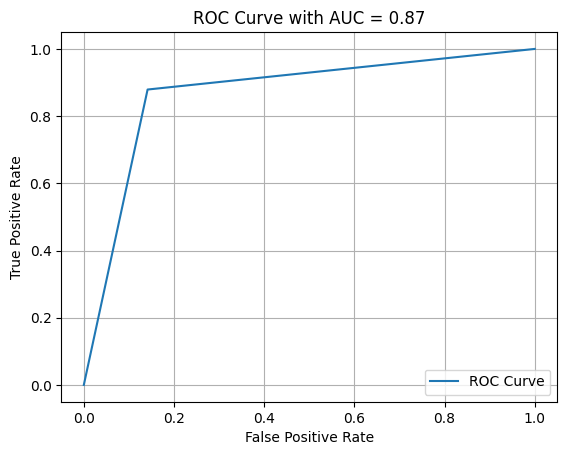

In [27]:

y_proba_test = grid_cv.predict_proba(x_test3)[:, 1]

# Obliczanie TPR, FPR i wyznaczanie progów dla krzywej ROC
fpr, tpr, thresholds = roc_curve(y_test3, y_proba_test)

# Rysowanie krzywej ROC
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC = {:.2f}'.format(roc_auc_score(y_test3, y_proba_test)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## SIECI NEURONOWE

## ANN

In [28]:
ann = tf.keras.models.Sequential()

In [29]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)


In [30]:
ann.add(tf.keras.layers.Dense(units=14, activation='relu'))

In [31]:
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))

In [32]:
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [33]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [34]:
ann.fit(x_train3, y_train3, batch_size = 32, epochs=100,
          validation_data=(x_test3, y_test3), verbose=1,
          callbacks=[early_stop])

Epoch 1/100


6373/6373 [==============================] - 11s 2ms/step - loss: 0.5132 - accuracy: 0.7459 - val_loss: 0.4688 - val_accuracy: 0.7763
Epoch 2/100
6373/6373 [==============================] - 12s 2ms/step - loss: 0.4431 - accuracy: 0.7877 - val_loss: 0.4167 - val_accuracy: 0.8000
Epoch 3/100
6373/6373 [==============================] - 12s 2ms/step - loss: 0.3954 - accuracy: 0.8117 - val_loss: 0.3752 - val_accuracy: 0.8222
Epoch 4/100
6373/6373 [==============================] - 11s 2ms/step - loss: 0.3717 - accuracy: 0.8222 - val_loss: 0.3657 - val_accuracy: 0.8242
Epoch 5/100
6373/6373 [==============================] - 12s 2ms/step - loss: 0.3597 - accuracy: 0.8273 - val_loss: 0.3521 - val_accuracy: 0.8305
Epoch 6/100
6373/6373 [==============================] - 11s 2ms/step - loss: 0.3529 - accuracy: 0.8299 - val_loss: 0.3519 - val_accuracy: 0.8300
Epoch 7/100
6373/6373 [==============================] - 11s 2ms/step - loss: 0.3489 - accuracy: 0.8316 - val_loss: 0.3482

In [35]:
ypred_train1 = ann.predict(x_train3)
y_pred_test1 = ann.predict(x_test3)

y_pred_test1 = (y_pred_test1 > 0.5)
ypred_train1 = (ypred_train1 > 0.5)
print(np.concatenate((y_pred_test1.reshape(len(y_pred_test1),1), y_test3.reshape(len(y_test3),1)),1))

2125/2125 [==============================] - 2s 800us/step
[[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [0. 0.]
 [0. 0.]
 [1. 1.]]


In [36]:
accuracy_score(y_test3, y_pred_test1)

0.836771023362561

In [37]:
print("Training Results\n")
print(classification_report(y_train3, ypred_train1))

Training Results

              precision    recall  f1-score   support

         0.0       0.77      0.97      0.86    102726
         1.0       0.96      0.71      0.82    101187

    accuracy                           0.84    203913
   macro avg       0.86      0.84      0.84    203913
weighted avg       0.86      0.84      0.84    203913



In [38]:
print('Testing Results\n')
print(classification_report(y_test3, y_pred_test1))

Testing Results

              precision    recall  f1-score   support

         0.0       0.77      0.97      0.85     33686
         1.0       0.96      0.71      0.81     34286

    accuracy                           0.84     67972
   macro avg       0.86      0.84      0.83     67972
weighted avg       0.86      0.84      0.83     67972



2125/2125 [==============================] - 2s 790us/step


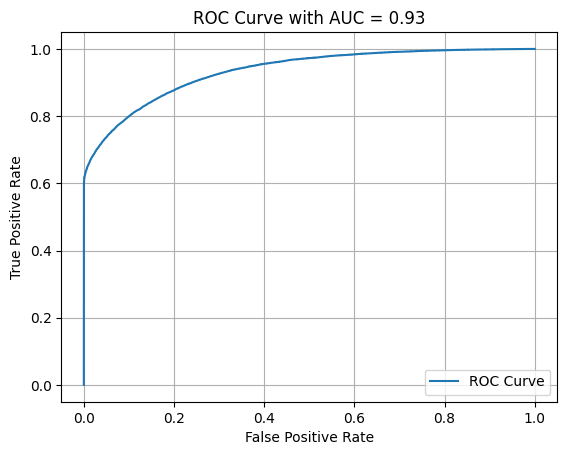

In [39]:

y_proba_test = ann.predict(x_test3).flatten()

fpr, tpr, thresholds = roc_curve(y_test3, y_proba_test)

plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC = {:.2f}'.format(roc_auc_score(y_test3, y_proba_test)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## inne próby sieci neuronowych 

In [40]:

tf.random.set_seed(42)


model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(14,activation = 'relu'),
  tf.keras.layers.Dense(6,activation = 'relu'),
  tf.keras.layers.Dense(6,activation = 'relu'),
  tf.keras.layers.Dense(1,activation = 'sigmoid')                            
])


model_2.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(lr=0.001),
                metrics = ['accuracy'])


history_2 = model_2.fit(x_train3,y_train3,epochs = 100)

Epoch 1/100
6373/6373 [==============================] - 9s 1ms/step - loss: 0.4940 - accuracy: 0.7597
Epoch 2/100
6373/6373 [==============================] - 9s 1ms/step - loss: 0.3975 - accuracy: 0.8124
Epoch 3/100
6373/6373 [==============================] - 8s 1ms/step - loss: 0.3612 - accuracy: 0.8274
Epoch 4/100
6373/6373 [==============================] - 7s 1ms/step - loss: 0.3468 - accuracy: 0.8329
Epoch 5/100
6373/6373 [==============================] - 7s 1ms/step - loss: 0.3403 - accuracy: 0.8362
Epoch 6/100
6373/6373 [==============================] - 7s 1ms/step - loss: 0.3376 - accuracy: 0.8365
Epoch 7/100
6373/6373 [==============================] - 6s 1ms/step - loss: 0.3341 - accuracy: 0.8383
Epoch 8/100
6373/6373 [==============================] - 6s 1ms/step - loss: 0.3332 - accuracy: 0.8395
Epoch 9/100
6373/6373 [==============================] - 6s 988us/step - loss: 0.3313 - accuracy: 0.8393
Epoch 10/100
6373/6373 [==============================] - 7s 1ms/step -

In [41]:
model_2.evaluate(x_test3,y_test3)

2125/2125 [==============================] - 3s 1ms/step - loss: 0.3024 - accuracy: 0.8522


[0.30244195461273193, 0.8521597385406494]

In [42]:
ypred_train4 = model_2.predict(x_train3)
y_pred_test4 = model_2.predict(x_test3)

y_pred_test4 = (y_pred_test4 > 0.5)
ypred_train4 = (ypred_train4 > 0.5)

print("Training Results\n")
print(classification_report(y_train3,ypred_train4))
print("Testing Results\n")
print(classification_report(y_test3,y_pred_test4))

2125/2125 [==============================] - 2s 712us/step
Training Results

              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87    102726
         1.0       0.92      0.78      0.84    101187

    accuracy                           0.85    203913
   macro avg       0.86      0.85      0.85    203913
weighted avg       0.86      0.85      0.85    203913

Testing Results

              precision    recall  f1-score   support

         0.0       0.80      0.93      0.86     33686
         1.0       0.92      0.78      0.84     34286

    accuracy                           0.85     67972
   macro avg       0.86      0.85      0.85     67972
weighted avg       0.86      0.85      0.85     67972



2125/2125 [==============================] - 2s 992us/step


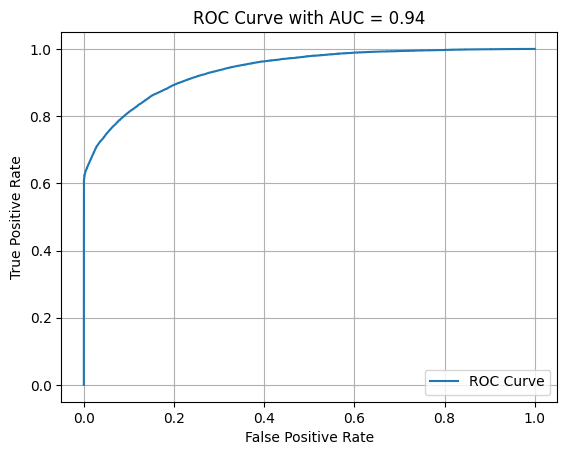

In [43]:

y_proba_test = model_2.predict(x_test3).flatten()

fpr, tpr, thresholds = roc_curve(y_test3, y_proba_test)

plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC = {:.2f}'.format(roc_auc_score(y_test3, y_proba_test)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## inna proba 

In [44]:

tf.random.set_seed(42)



model_22 = tf.keras.Sequential([
  tf.keras.layers.Dense(18,activation = 'relu'),
  tf.keras.layers.Dense(36,activation = 'relu'),
  tf.keras.layers.Dense(18,activation = 'relu'),
  tf.keras.layers.Dense(9,activation = 'relu'),
  tf.keras.layers.Dense(1,activation = 'sigmoid')                            
])


model_22.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(lr=0.001),
                metrics = ['accuracy'])


history_2 = model_22.fit(x_train3,y_train3,epochs = 100)

Epoch 1/100
6373/6373 [==============================] - 9s 1ms/step - loss: 0.4765 - accuracy: 0.7695
Epoch 2/100
6373/6373 [==============================] - 7s 1ms/step - loss: 0.3731 - accuracy: 0.8206
Epoch 3/100
6373/6373 [==============================] - 9s 1ms/step - loss: 0.3413 - accuracy: 0.8323
Epoch 4/100
6373/6373 [==============================] - 9s 1ms/step - loss: 0.3295 - accuracy: 0.8376
Epoch 5/100
6373/6373 [==============================] - 9s 1ms/step - loss: 0.3234 - accuracy: 0.8406
Epoch 6/100
6373/6373 [==============================] - 9s 1ms/step - loss: 0.3184 - accuracy: 0.8431
Epoch 7/100
6373/6373 [==============================] - 9s 1ms/step - loss: 0.3154 - accuracy: 0.8443
Epoch 8/100
6373/6373 [==============================] - 10s 2ms/step - loss: 0.3117 - accuracy: 0.8465
Epoch 9/100
6373/6373 [==============================] - 8s 1ms/step - loss: 0.3077 - accuracy: 0.8485
Epoch 10/100
6373/6373 [==============================] - 9s 1ms/step - 

In [45]:
model_22.evaluate(x_test3,y_test3)

2125/2125 [==============================] - 3s 1ms/step - loss: 0.2882 - accuracy: 0.8603


[0.2881743907928467, 0.8603395223617554]

In [46]:
ypred_train22 = model_22.predict(x_train3)
y_pred_test22 = model_22.predict(x_test3)

y_pred_test22 = (y_pred_test22 > 0.5)
ypred_train22 = (ypred_train22 > 0.5)

print(classification_report(y_train3,ypred_train22))
print(classification_report(y_test3,y_pred_test22))

2125/2125 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.86    102726
         1.0       0.87      0.85      0.86    101187

    accuracy                           0.86    203913
   macro avg       0.86      0.86      0.86    203913
weighted avg       0.86      0.86      0.86    203913

              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86     33686
         1.0       0.87      0.85      0.86     34286

    accuracy                           0.86     67972
   macro avg       0.86      0.86      0.86     67972
weighted avg       0.86      0.86      0.86     67972



   1/2125 [..............................] - ETA: 1:06

2125/2125 [==============================] - 3s 1ms/step


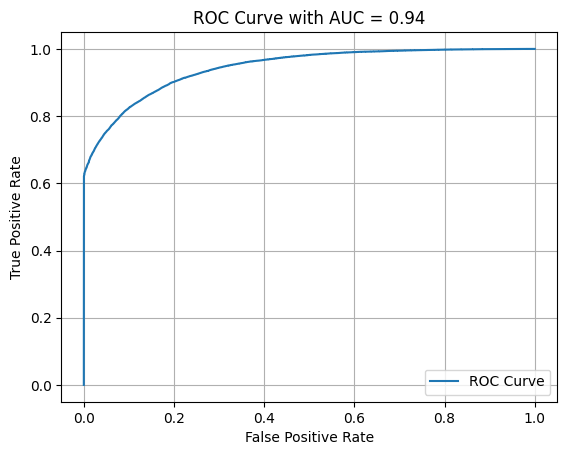

In [47]:

y_proba_test = model_22.predict(x_test3).flatten()

fpr, tpr, thresholds = roc_curve(y_test3, y_proba_test)

plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC = {:.2f}'.format(roc_auc_score(y_test3, y_proba_test)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## inne próby sieci neuronowych 

In [48]:
model = Sequential()
model.add(Dense(units=30,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=15,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [49]:
model.fit(x=x_train3, 
          y=y_train3, 
          epochs=100,
          validation_data=(x_test3, y_test3), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/100
6373/6373 [==============================] - 12s 2ms/step - loss: 0.5739 - val_loss: 0.4981
Epoch 2/100
6373/6373 [==============================] - 11s 2ms/step - loss: 0.5278 - val_loss: 0.4747
Epoch 3/100
6373/6373 [==============================] - 10s 2ms/step - loss: 0.5140 - val_loss: 0.4651
Epoch 4/100
6373/6373 [==============================] - 10s 2ms/step - loss: 0.5078 - val_loss: 0.4570
Epoch 5/100
6373/6373 [==============================] - 11s 2ms/step - loss: 0.5037 - val_loss: 0.4551
Epoch 6/100
6373/6373 [==============================] - 10s 2ms/step - loss: 0.5018 - val_loss: 0.4495
Epoch 7/100
6373/6373 [==============================] - 11s 2ms/step - loss: 0.5010 - val_loss: 0.4435
Epoch 8/100
6373/6373 [==============================] - 11s 2ms/step - loss: 0.4986 - val_loss: 0.4459
Epoch 9/100
6373/6373 [==============================] - 10s 2ms/step - loss: 0.4968 - val_loss: 0.4429
Epoch 10/100
6373/6373 [==============================] - 9s 1ms

In [50]:
ypred_train5 = model.predict(x_train3)
y_pred_test5 = model.predict(x_test3)

y_pred_test5 = (y_pred_test5 > 0.5)
ypred_train5 = (ypred_train5 > 0.5)

print(classification_report(y_train3,ypred_train5))
print(classification_report(y_test3,y_pred_test5))

2125/2125 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

         0.0       0.83      0.78      0.80    102726
         1.0       0.79      0.84      0.81    101187

    accuracy                           0.81    203913
   macro avg       0.81      0.81      0.81    203913
weighted avg       0.81      0.81      0.81    203913

              precision    recall  f1-score   support

         0.0       0.83      0.78      0.80     33686
         1.0       0.79      0.84      0.82     34286

    accuracy                           0.81     67972
   macro avg       0.81      0.81      0.81     67972
weighted avg       0.81      0.81      0.81     67972



2125/2125 [==============================] - 2s 1ms/step


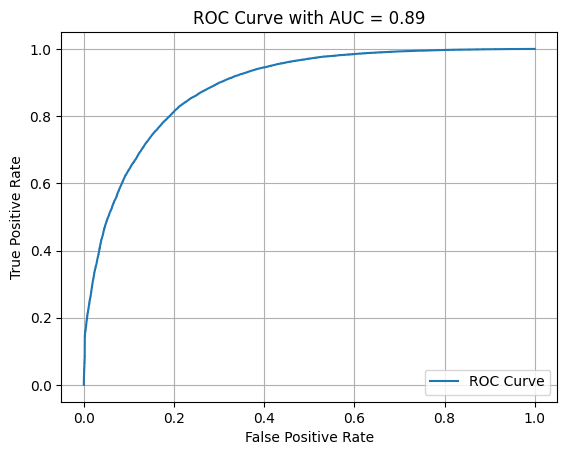

In [51]:
y_proba_test = model.predict(x_test3).flatten()

fpr, tpr, thresholds = roc_curve(y_test3, y_proba_test)

plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC = {:.2f}'.format(roc_auc_score(y_test3, y_proba_test)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## inny model

In [52]:
model11 = Sequential()


model11.add(Dense(14,  activation='relu'))
model11.add(Dropout(0.2))

model11.add(Dense(10, activation='relu'))
model11.add(Dropout(0.2))

model11.add(Dense(units=1,activation='sigmoid'))

model11.compile(loss='binary_crossentropy', optimizer='adam')

In [53]:
model11.fit(x=x_train3, 
          y=y_train3, 
          epochs=100,
          validation_data=(x_test3, y_test3), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/100
6373/6373 [==============================] - 11s 2ms/step - loss: 0.5545 - val_loss: 0.4966
Epoch 2/100
6373/6373 [==============================] - 8s 1ms/step - loss: 0.5125 - val_loss: 0.4714
Epoch 3/100
6373/6373 [==============================] - 8s 1ms/step - loss: 0.4996 - val_loss: 0.4575
Epoch 4/100
6373/6373 [==============================] - 8s 1ms/step - loss: 0.4926 - val_loss: 0.4507
Epoch 5/100
6373/6373 [==============================] - 8s 1ms/step - loss: 0.4867 - val_loss: 0.4447
Epoch 6/100
6373/6373 [==============================] - 8s 1ms/step - loss: 0.4838 - val_loss: 0.4399
Epoch 7/100
6373/6373 [==============================] - 11s 2ms/step - loss: 0.4831 - val_loss: 0.4419
Epoch 8/100
6373/6373 [==============================] - 11s 2ms/step - loss: 0.4825 - val_loss: 0.4349
Epoch 9/100
6373/6373 [==============================] - 10s 2ms/step - loss: 0.4799 - val_loss: 0.4404
Epoch 10/100
6373/6373 [==============================] - 10s 2ms/ste

In [54]:
ypred_train7 = model11.predict(x_train3)
y_pred_test7 = model11.predict(x_test3)

y_pred_test7 = (y_pred_test7 > 0.5)
ypred_train7 = (ypred_train7 > 0.5)

print(classification_report(y_train3,ypred_train7))
print(classification_report(y_test3,y_pred_test7))

2125/2125 [==============================] - 3s 1ms/step
              precision    recall  f1-score   support

         0.0       0.84      0.77      0.80    102726
         1.0       0.78      0.85      0.81    101187

    accuracy                           0.81    203913
   macro avg       0.81      0.81      0.81    203913
weighted avg       0.81      0.81      0.81    203913

              precision    recall  f1-score   support

         0.0       0.84      0.77      0.80     33686
         1.0       0.79      0.85      0.82     34286

    accuracy                           0.81     67972
   macro avg       0.81      0.81      0.81     67972
weighted avg       0.81      0.81      0.81     67972



2125/2125 [==============================] - 2s 1ms/step


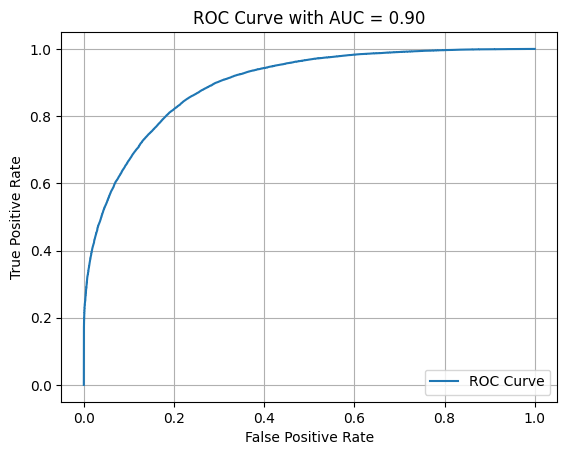

In [55]:

y_proba_test = model11.predict(x_test3).flatten()

fpr, tpr, thresholds = roc_curve(y_test3, y_proba_test)

plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC = {:.2f}'.format(roc_auc_score(y_test3, y_proba_test)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## SVC

In [56]:
model3 = SVC(probability=True)

In [57]:
model3.fit(x_train3,y_train3)

SVC(probability=True)

In [58]:
ypred_train9 = model3.predict(x_train3)
y_pred_test9 = model3.predict(x_test3)


print(classification_report(y_train3,ypred_train9))
print(classification_report(y_test3,y_pred_test9))

              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86    102726
         1.0       0.89      0.79      0.84    101187

    accuracy                           0.85    203913
   macro avg       0.86      0.85      0.85    203913
weighted avg       0.85      0.85      0.85    203913

              precision    recall  f1-score   support

         0.0       0.81      0.91      0.86     33686
         1.0       0.90      0.79      0.84     34286

    accuracy                           0.85     67972
   macro avg       0.85      0.85      0.85     67972
weighted avg       0.85      0.85      0.85     67972



In [59]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)

In [60]:
grid.fit(x_train3,y_train3)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


ValueError: Invalid parameter 'learning_rate' for estimator SVC(). Valid parameters are: ['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'].

In [ ]:
grid.best_params_

In [ ]:
grid.best_estimator_

In [ ]:
ypred_train = grid.predict(x_train3)
y_pred_test = grid.predict(x_test3)


print(classification_report(y_train3,ypred_train))
print(classification_report(y_test3,y_pred_test))

In [ ]:

y_proba_test = grid.predict_proba(x_test3)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test3, y_proba_test)

plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC = {:.2f}'.format(roc_auc_score(y_test3, y_proba_test)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Training Results

              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84    102726
         1.0       0.85      0.81      0.83    101187

    accuracy                           0.83    203913
   macro avg       0.83      0.83      0.83    203913
weighted avg       0.83      0.83      0.83    203913

Testing Results

              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83     33686
         1.0       0.85      0.80      0.83     34286

    accuracy                           0.83     67972
   macro avg       0.83      0.83      0.83     67972
weighted avg       0.83      0.83      0.83     67972



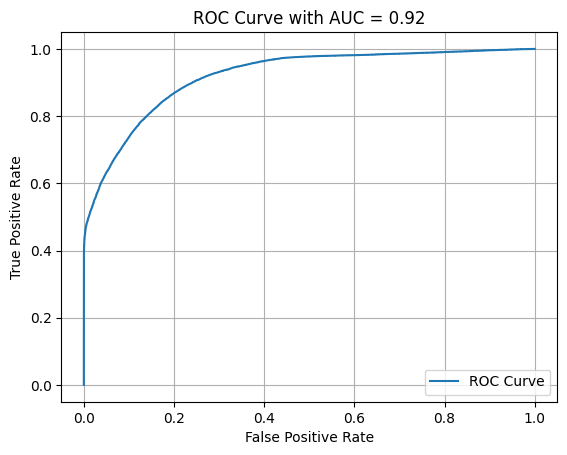

In [61]:
model3 = SVC(C=0.1, gamma=1, kernel='rbf', probability=True)
model3.fit(x_train3, y_train3)

ypred_train14 = model3.predict(x_train3)
y_pred_test14 = model3.predict(x_test3)

print("Training Results\n")
print(classification_report(y_train3, ypred_train14))
print("Testing Results\n")
print(classification_report(y_test3, y_pred_test14))

y_proba_test = model3.predict_proba(x_test3)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test3, y_proba_test)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC = {:.2f}'.format(roc_auc_score(y_test3, y_proba_test)))
plt.legend(loc='lower right')
plt.grid(True)
plt.show()